## Explorando os dados

Este script tem 2 grandes objetivos, sendo:

#### Investigar a qualidade dos dados

Analisar a qualidade dos dados, buscando inconsistências que possam afetar os resultados de análises futuras e endereçar tratamentos adequados.

A estratégia para tratamento dos dados será criar novas tabelas com o prefixo `refined_`, onde serão aplicadas regras de negócio ou de tratamento em geral dos dados. A ideia é manter os dados originais que foram importados nas etapas anteriores do teste e criar novas visões que sejam específicas para realização de análises. Pensando em um dia-a-dia de trabalho, o processo ideal seria mapear com as áreas responsáveis os casos de inconsistências de dados na fonte do problema, visando identificar resolução em sua causa raíz.

#### Análise exploratória
Uma vez tendo confiança sobre a qualidade dos dados, será realizada uma análise exploratória com intuito de conhecer um pouco mais sobre os dados e coletar insights que podem ser relevantes

#### Import das libs

In [1]:
#Importando das libs que serão utilizadas no processo
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### Conectando ao banco e iniciando o cursor

In [2]:
#conectando ao banco de dados test_analytics_engineer
conn = sqlite3.connect('test_analytics_engineer.db')

In [3]:
#instanciando o cursor
c = conn.cursor()

### Investigar a qualidade dos dados

##### country

In [30]:
# olhando os dados da base
df = pd.read_sql('SELECT * FROM country',conn)
df.sort_values(by='id').head(20)

,id,name
16,0.0,None
11,1.0,Bélgica
0,1.0,Belgium
1,1729.0,England
12,1729.0,Inglaterra
13,4769.0,França
2,4769.0,France
3,7809.0,Germany
14,7809.0,Alemanha
4,10257.0,Italy


**Inconsistências ou oportunidade de melhorias:**
- Duplicidade na coluna id. **Solução proposta:** agregar pelo id, separando as colunas por idiomas
- Nomes dos países em 2 idiomas diferentes. **Solução proposta:** agregar pelo id, separando as colunas por idiomas
- Nem todos os países tem os nomes em ambos idiomas: **Solução proposta:** inserir manualmente os valores faltantes
- Dado com id 0 e sem informação de country: **Solução proposta:** remover da tabela
- Dado nulo. **Solução proposta:** remover da tabela

In [42]:
#Removendo linhas sem informação de country
df_clean = df.dropna()
df_clean.isna().sum()

id      0
name    0
dtype: int64

In [43]:
#criando idiomas que estão faltando
language_dict = [
                    {'id': 13274, 'name':'Holanda'},
                    {'id': 15722, 'name':'Polônia'},
                    {'id': 19694, 'name':'Escócia'},
                    {'id': 21518, 'name':'Espanha'},
                    {'id': 24558, 'name':'Suíça'}
                ]
df_new_languages = pd.DataFrame.from_dict(language_dict)
df_new_languages.head()

,id,name
0,13274,Holanda
1,15722,Polônia
2,19694,Escócia
3,21518,Espanha
4,24558,Suíça


In [48]:
#inserindo idiomas faltantes no df geral
df_clean = pd.concat([df_clean,df_new_languages])
df_clean.groupby('id').count()['name']

id
1.0        2
1729.0     2
4769.0     2
7809.0     2
10257.0    2
13274.0    2
15722.0    2
17642.0    1
19694.0    2
21518.0    2
24558.0    2
Name: name, dtype: int64

Portugal ficou sem porque tem a mesma escrita, portanto era esperado

In [74]:
#criando um df para cada idioma
en_us = ['Belgium','England','France','Germany','Italy','Netherlands','Poland','Portugal','Scotland','Spain','Switzerland']
pt_br = ['Bélgica','Inglaterra','França','Alemanha','Itália','Holanda','Polônia','Portugal','Escócia','Espanha','Suíça']

df_en_us = df_clean[df_clean['name'].isin(en_us)]
df_pt_br = df_clean[df_clean['name'].isin(pt_br)]

#renomeando as colunas name
df_en_us = df_en_us.rename(columns={'name':'name_en_us'})
df_pt_br = df_pt_br.rename(columns={'name':'name_pt_br'})

#mergeando os df's para criar a versão final da base
df_clean = df_en_us.merge(df_pt_br)

In [77]:
#checando resultados
df_clean.head()

,id,name_en_us,name_pt_br
0,1.0,Belgium,Bélgica
1,1729.0,England,Inglaterra
2,4769.0,France,França
3,7809.0,Germany,Alemanha
4,10257.0,Italy,Itália


In [81]:
#criando a tabela refined_
c.execute('''
    CREATE TABLE IF NOT EXISTS refined_country (
        id INT,
        name_en_us TEXT,
        name_pt_br TEXT
    )
''')

#inserindo os dados
df_clean.to_sql('refined_country',conn,if_exists='append',index=False)

11

In [82]:
#fazendo um check rápido no banco
c.execute('SELECT * FROM refined_country').fetchall()

[(1, 'Belgium', 'Bélgica'),
 (1729, 'England', 'Inglaterra'),
 (4769, 'France', 'França'),
 (7809, 'Germany', 'Alemanha'),
 (10257, 'Italy', 'Itália'),
 (13274, 'Netherlands', 'Holanda'),
 (15722, 'Poland', 'Polônia'),
 (17642, 'Portugal', 'Portugal'),
 (19694, 'Scotland', 'Escócia'),
 (21518, 'Spain', 'Espanha'),
 (24558, 'Switzerland', 'Suíça')]

In [96]:
#commitando alteração
conn.commit()

##### league

In [84]:
# olhando os dados da base
df = pd.read_sql('SELECT * FROM league',conn)
df.sort_values(by='id')

,id,country_id,name
0,1,1,Belgium Jupiler League
2,1729,1729,England Premier League
3,4769,4769,France Ligue 1
4,7809,7809,Germany 1. Bundesliga
5,10257,10257,Italy Serie A
7,13274,13274,Netherlands Eredivisie
8,15722,15722,Poland Ekstraklasa
9,17642,17642,Portugal Liga ZON Sagres
10,19694,19694,Scotland Premier League
11,21518,21518,Spain LIGA BBVA


Apesar de o id ser exatamente igual ao country_id, acredito que não vale o esforço de remover esta coluna sem acesso ao entendimento mais profundo da diferença entre estas colunas. Sendo assim, nenhum tratamento se faz necessário nesta tabela

In [76]:
#criando a tabela refined_
c.execute('''
        CREATE TABLE IF NOT EXISTS refined_league AS
        SELECT
            id,
            country_id,
            name
        FROM
            league
''')

In [77]:
#checando os dados
c.execute('SELECT * FROM refined_league LIMIT 5').fetchall()

[(1, '1', 'Belgium Jupiler League'),
 (44560, '44560', 'Brasileirão Série A'),
 (1729, '1729', 'England Premier League'),
 (4769, '4769', 'France Ligue 1'),
 (7809, '7809', 'Germany 1. Bundesliga')]

In [78]:
#commitando criação da tabela
conn.commit()

##### match

In [101]:
# olhando os dados da base
df = pd.read_sql('SELECT * FROM match',conn)
df.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [144]:
#checando duplicidades
duplicated_id = df.duplicated(subset=['id']).sum()
duplicated_match_id = df.duplicated(subset=['match_api_id']).sum()
duplicated_home_team_date = df.duplicated(subset=['home_team_api_id','date']).sum()

print(duplicated_id,duplicated_match_id,duplicated_home_team_date)

0 0 0


Não foram encontradas duplicidades nas colunas que podem ser utilizadas como chave.

Sobre a combinação `home_team_api_id` + `date`, a ideia era validar se existia alguma consistência de um time jogando na mesma data, porém isso não acontece

In [128]:
#checando valores nulos
total = df.count()['id']
columns = list(df.columns)
for column in columns:
    na = df[column].isna().sum()
    na_rate = round((na / total * 100),2)
    print(column + ':' + str(na_rate))


id:0.0
country_id:0.0
league_id:0.0
season:0.0
stage:0.0
date:0.0
match_api_id:0.0
home_team_api_id:0.0
away_team_api_id:0.0
home_team_goal:0.0
away_team_goal:0.0
home_player_X1:7.01
home_player_X2:7.01
home_player_X3:7.05
home_player_X4:7.05
home_player_X5:7.05
home_player_X6:7.05
home_player_X7:7.05
home_player_X8:7.05
home_player_X9:7.05
home_player_X10:7.05
home_player_X11:7.05
away_player_X1:7.05
away_player_X2:7.05
away_player_X3:7.05
away_player_X4:7.05
away_player_X5:7.05
away_player_X6:7.05
away_player_X7:7.05
away_player_X8:7.05
away_player_X9:7.06
away_player_X10:7.06
away_player_X11:7.08
home_player_Y1:7.01
home_player_Y2:7.01
home_player_Y3:7.05
home_player_Y4:7.05
home_player_Y5:7.05
home_player_Y6:7.05
home_player_Y7:7.05
home_player_Y8:7.05
home_player_Y9:7.05
home_player_Y10:7.05
home_player_Y11:7.05
away_player_Y1:7.05
away_player_Y2:7.05
away_player_Y3:7.05
away_player_Y4:7.05
away_player_Y5:7.05
away_player_Y6:7.05
away_player_Y7:7.05
away_player_Y8:7.05
away_player

Avaliando o resultado é possível identificar que algumas colunas importantes no aspecto de análise tem uma eleveada taxa de valores nulos:
- goal: 45.28
- shoton: 45.28
- shotoff: 45.28
- foulcommit: 45.28
- card: 45.28
- cross: 45.28
- corner: 45.28
- possession: 45.28

Como a taxa de nulos é exatamente igual, estimo que estas informações venham da mesma fonte ou possuem o mesmo gap de atualização

In [158]:
#chegando alguns dados de uma dessas colunas com alto rate de nulo
pd.set_option(
    'display.max_colwidth', 500
)
df[df['goal'].notna()]['goal'].head(1)

1728    <goal><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>406</event_incident_typefk><elapsed>22</elapsed><player2>38807</player2><subtype>header</subtype><player1>37799</player1><sortorder>5</sortorder><team>10261</team><id>378998</id><n>295</n><type>goal</type><goal_type>n</goal_type></value><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>393</event_incident_typefk><elapsed>24</elapsed><player...
Name: goal, dtype: object

In [164]:
#agrupando dados por data para entender ranges
df.groupby(pd.to_datetime(df.date)).count()['id'].reset_index()

,date,id
0,2008-07-18,1
1,2008-07-19,1
2,2008-07-20,2
3,2008-07-23,3
4,2008-07-24,2
...,...,...
1689,2016-05-15,26
1690,2016-05-16,5
1691,2016-05-17,1
1692,2016-05-22,5


In [165]:
#realizando mesmo agrupamento de datas onde a coluna goal é nula
df_test = df[df['goal'].isna()]
df.groupby(pd.to_datetime(df_test.date)).count()['id'].reset_index()

,date,id
0,2008-07-18,1
1,2008-07-19,1
2,2008-07-20,2
3,2008-07-23,3
4,2008-07-24,2
...,...,...
1515,2016-05-10,1
1516,2016-05-11,4
1517,2016-05-12,1
1518,2016-05-14,9


Como podemos identificar no agrupamento, não é um problema legado que foi corrigido à partir de uma data. Temos linhas com dado nulo nos mesmos ranges da tabela como um todo. Portanto, é um problema ainda existente nos dados mais recentes da tabela.

Apesar de serem colunas que contém eventos que aconteceram no jogo, o alto índice de partidas com valores nulos pode fazer com que insights sejam precipitados. A recomendação seria entender na fonte do problema o porquê de partidas virem com dados nulos, corrigir o problema e quando tiver um volume maior de dados preenchidos realizar as análises

Text(0.5, 1.0, 'Distribuição de partidas por country id')

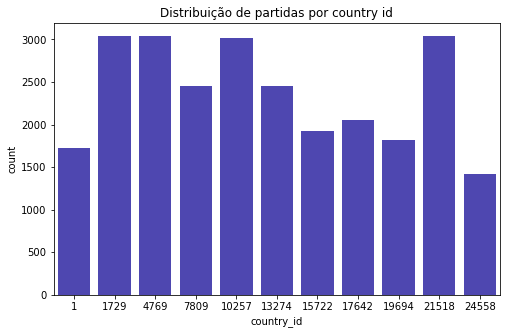

In [192]:
#avaliando distribuição de country_id
plt.figure(figsize=(8,5))
sns.countplot(x=df["country_id"],color='#3F35C1')
plt.title('Distribuição de partidas por country id')

Os dados de country parecem estar ok

Text(0.5, 1.0, 'Distribuição de partidas por league id')

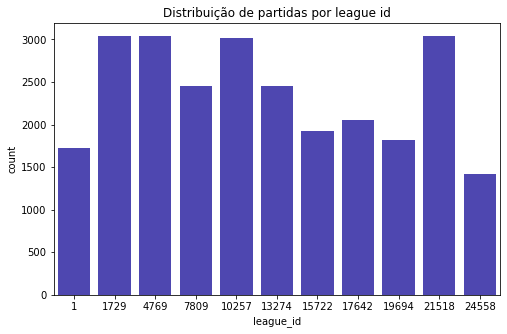

In [193]:
#avaliando distribuição de league_id
plt.figure(figsize=(8,5))
sns.countplot(x=df["league_id"],color='#3F35C1')
plt.title('Distribuição de partidas por league id')

A distruição é exatamente igual à de country_id, o que faz sentido visto que já foi identificado que as colunas possuem o mesmo dado

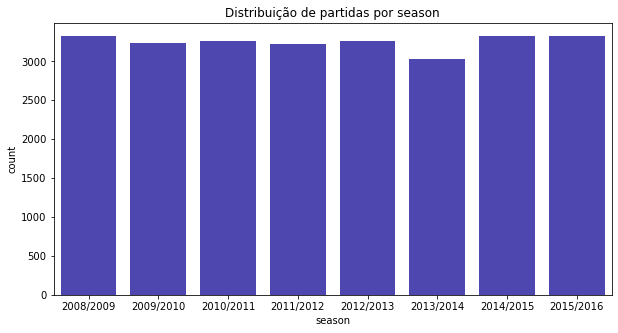

In [196]:
#avaliando distribuição de league_id
plt.figure(figsize=(10,5))
sns.countplot(x=df["season"],color='#3F35C1')
plt.title('Distribuição de partidas por season');

Dados bem distribuídos entre as seasons

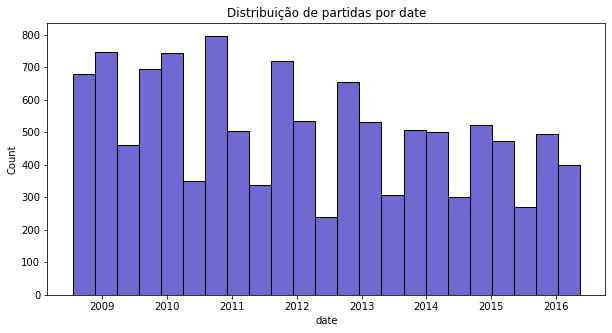

In [201]:
#avaliando distribuição de date
plt.figure(figsize=(10,5))
sns.histplot(x=pd.to_datetime(df_test.date),color='#3F35C1')
plt.title('Distribuição de partidas por date');

Apesar de os dados estarem em uma tendência de queda ao longo do tempo, temos uma quantidade de dados relevante para cada ano.

É interessante também que conseguimos observar a queda no volume de dados na metade do ano, que é quando existe o período de transição entre uma temporada e outra (principalmente na Europa) e não existem tantas partidas acontecendo.

In [138]:
#avaliando estatísticas das colunas home_team_goal e away_team_goal
df[['home_team_goal','away_team_goal']].describe()

,home_team_goal,away_team_goal
count,25979.000000,25979.000000
mean,1.544594,1.160938
std,1.297158,1.142110
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,10.000000,9.000000


Alguns pontos que chamam a atenção:

- Apesar de ter alguns outliers nos valores máximos, os dados destas colunas estão coerentes. No futebol, apesar de mais raro, placars elásticos são possíveis então 7 ou 10 gols é um resultado perfeitamente possível
- A média de gols dos times que jogam como mandantes e tem apoio de sua torcida é superior. É um comportamento esperado uma vez que, mesmo de forma não tangível, o apoio dos torcedores historicamente parece ter influência no desempenho do time da casa

In [212]:
#checando as colunas home_player_X
df[['home_player_X1','home_player_X2','away_player_X1','away_player_X2','home_player_Y1','home_player_Y2','away_player_Y1','away_player_Y2']].describe()

,home_player_X1,home_player_X2,away_player_X1,away_player_X2,home_player_Y1,home_player_Y2,away_player_Y1,away_player_Y2
count,24158.000000,24158.000000,24147.000000,24147.000000,24158.000000,24158.000000,24147.000000,24147.0
mean,0.999586,2.073516,1.000290,2.074585,0.999627,2.998634,1.000248,3.0
std,0.022284,0.387185,0.033438,0.403572,0.024916,0.064003,0.022292,0.0
min,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,3.0
25%,1.000000,2.000000,1.000000,2.000000,1.000000,3.000000,1.000000,3.0
50%,1.000000,2.000000,1.000000,2.000000,1.000000,3.000000,1.000000,3.0
75%,1.000000,2.000000,1.000000,2.000000,1.000000,3.000000,1.000000,3.0
max,2.000000,8.000000,6.000000,8.000000,3.000000,3.000000,3.000000,3.0


**Inconsistências ou oportunidade de melhorias:**
- Apesar de terem dados relevantes, as colunas de eventos do jogo (ex: goal,shoton,shotoff,foulcommit,etc) possuem um alto índice de dados nulos. **Solução proposta:** remover da tabela
- Para muitas colunas fica difícil determinar o objetivo do dado sem uma documentação (ex: B365H,B365D,B365A, etc). **Solução proposta:** remover da tabela
- Não temos uma coluna indicando o vencedor da partida, podendo ser facilmente criada à partir das colunas de goals (home e away). **Solução proposta:** criar colunas booleanas indicando vitória, derrota e empate
- O entendimendo das colunas home_player_X, away_player_X, home_player_Y, away_player_Y não estão muito claros. **Solução proposta:** remover da tabela

In [224]:
#criando a tabela refined_
c.execute('''
        CREATE TABLE IF NOT EXISTS refined_match AS
        SELECT
            id,
            country_id,
            league_id,
            season,
            stage,
            date,
            match_api_id,
            home_team_api_id,
            away_team_api_id,
            home_team_goal,
            away_team_goal,
            CASE WHEN home_team_goal > away_team_goal THEN TRUE ELSE FALSE END AS home_team_wins,
            CASE WHEN home_team_goal < away_team_goal THEN TRUE ELSE FALSE END AS away_team_wins,
            CASE WHEN home_team_goal = away_team_goal THEN TRUE ELSE FALSE END AS draw_match,
            home_player_1,
            home_player_2,
            home_player_3,
            home_player_4,
            home_player_5,
            home_player_6,
            home_player_7,
            home_player_8,
            home_player_9,
            home_player_10,
            home_player_11,
            away_player_1,
            away_player_2,
            away_player_3,
            away_player_4,
            away_player_5,
            away_player_6,
            away_player_7,
            away_player_8,
            away_player_9,
            away_player_10,
            away_player_11
        FROM
            match
''')

In [226]:
#checando os dados
c.execute('SELECT * FROM refined_match').fetchone()

(1,
 1,
 1,
 '2008/2009',
 1,
 '2008-08-17 00:00:00',
 492473,
 9987,
 9993,
 1,
 1,
 0,
 0,
 1,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None)

In [227]:
#commitando criação da base
conn.commit()

##### players_attributes_modified

In [4]:
# olhando os dados da base
df = pd.read_sql('SELECT * FROM player_attributes_modified',conn)
df.head()

,player_fifa_api_id,attribute_id,date,overall_rating,potential,preferred_foot,right,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,218353,1,2016-02-18 00:00:00,67.0,71.0,right,None,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,218353,2,2015-11-19 00:00:00,67.0,71.0,right,None,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,218353,3,2015-09-21 00:00:00,62.0,66.0,right,None,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,218353,4,2015-03-20 00:00:00,61.0,65.0,right,None,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,218353,5,2007-02-22 00:00:00,61.0,65.0,right,None,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [39]:
#checando linhas duplicadas no geral
df_test = df.drop('attribute_id',axis=1)
df_test.duplicated().sum()

62

Temos alguns casos de duplicidade de linhas totalmente iguais

In [37]:
#avaliando duplicidades com a chave da tabela
df.duplicated(subset=['player_fifa_api_id','date']).sum()

913

In [38]:
#checando os duplicados
df[df.duplicated(subset=['player_fifa_api_id','date'],keep=False)].sort_values(by=['player_fifa_api_id','date']).head(10)

,player_fifa_api_id,attribute_id,date,overall_rating,potential,preferred_foot,right,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
40185,61,40186,2007-02-22 00:00:00,70.0,86.0,right,None,medium,medium,59.0,...,58.0,55.0,33.0,25.0,31.0,11.0,6.0,47.0,7.0,6.0
40186,61,40187,2007-02-22 00:00:00,NaN,NaN,None,None,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122632,158,122633,2007-02-22 00:00:00,74.0,79.0,left,None,medium,medium,61.0,...,54.0,72.0,71.0,72.0,73.0,12.0,9.0,6.0,10.0,6.0
122633,158,122634,2007-02-22 00:00:00,NaN,NaN,None,None,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89362,599,89363,2007-02-22 00:00:00,74.0,75.0,right,None,norm,ormal,51.0,...,57.0,68.0,33.0,21.0,16.0,13.0,6.0,40.0,14.0,10.0
89363,599,89364,2007-02-22 00:00:00,NaN,NaN,None,None,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19094,838,19095,2007-02-22 00:00:00,72.0,73.0,right,None,medium,medium,71.0,...,69.0,74.0,55.0,69.0,59.0,12.0,13.0,70.0,14.0,11.0
19095,838,19096,2007-02-22 00:00:00,NaN,NaN,None,None,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59311,899,59312,2007-02-22 00:00:00,85.0,86.0,right,None,medium,medium,24.0,...,30.0,73.0,19.0,33.0,11.0,83.0,84.0,74.0,85.0,86.0
59312,899,59313,2007-02-22 00:00:00,NaN,NaN,None,None,None,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Avaliando alguns exemplos, além dos casos de duplicidade da linha inteira, temos duplicidades pela chave onde 1 linha possui informações preenchidas e outra possui valores nulos para os atributos

In [54]:
#checando nulos
df.isna().sum()

player_fifa_api_id          0
attribute_id                0
date                        0
overall_rating            787
potential                 787
preferred_foot            787
right                  183929
attacking_work_rate      3181
defensive_work_rate       787
crossing                  787
finishing                 787
heading_accuracy          787
short_passing             787
volleys                  2664
dribbling                 787
curve                    2664
free_kick_accuracy        787
long_passing              787
ball_control              787
acceleration              787
sprint_speed              787
agility                  2664
reactions                 787
balance                  2664
shot_power                787
jumping                  2664
stamina                   787
strength                  787
long_shots                787
aggression                787
interceptions             787
positioning               787
vision                   2664
penalties 

O volume de nulos está ok em quase todas as colunas, exceto na coluna `right`

In [41]:
#avaliando estatísticas das colunas
df.describe().T

,count,mean,std,min,25%,50%,75%,max
player_fifa_api_id,183929.0,165662.576228,53855.472340,2.0,155787.0,183486.0,199845.0,234141.0
attribute_id,183929.0,91978.226430,53112.547342,1.0,45983.0,91965.0,137972.0,183978.0
overall_rating,183142.0,68.600015,7.041139,33.0,64.0,69.0,73.0,94.0
potential,183142.0,73.460353,6.592271,39.0,69.0,74.0,78.0,97.0
crossing,183142.0,55.086883,17.242135,1.0,45.0,59.0,68.0,95.0
finishing,183142.0,49.921078,19.038705,1.0,34.0,53.0,65.0,97.0
heading_accuracy,183142.0,57.266023,16.488905,1.0,49.0,60.0,68.0,98.0
short_passing,183142.0,62.429672,14.194068,3.0,57.0,65.0,72.0,97.0
volleys,181265.0,49.468436,18.256618,1.0,35.0,52.0,64.0,93.0
dribbling,183142.0,59.175154,17.744688,1.0,52.0,64.0,72.0,97.0


Apesar de aparentar ter alguns outliers nos atributos no que diz respeito ao min, avaliando os percentis os dados parece estar ok

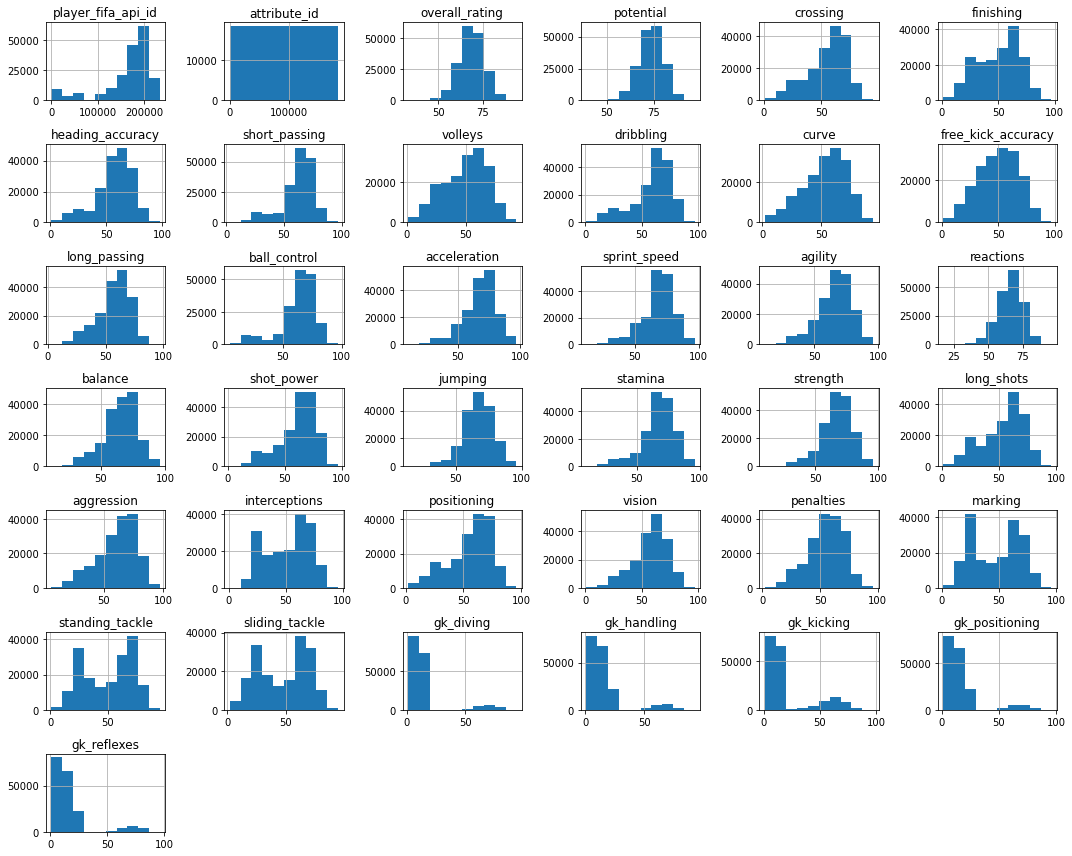

In [52]:
#confirmando distribuição dos dados
df.hist(figsize=(15, 12))
plt.tight_layout()

De fato, os dados parecem estar ok.

A distribuição dos atributos que iniciam com gk estão um pouco diferentes, com maior concentração em valores mais baixos. Isso faz sentido, já que é uma posição que possui muito menos jogadores aptos à atuarem

In [55]:
df.head()

,player_fifa_api_id,attribute_id,date,overall_rating,potential,preferred_foot,right,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,218353,1,2016-02-18 00:00:00,67.0,71.0,right,None,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,218353,2,2015-11-19 00:00:00,67.0,71.0,right,None,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,218353,3,2015-09-21 00:00:00,62.0,66.0,right,None,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,218353,4,2015-03-20 00:00:00,61.0,65.0,right,None,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,218353,5,2007-02-22 00:00:00,61.0,65.0,right,None,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


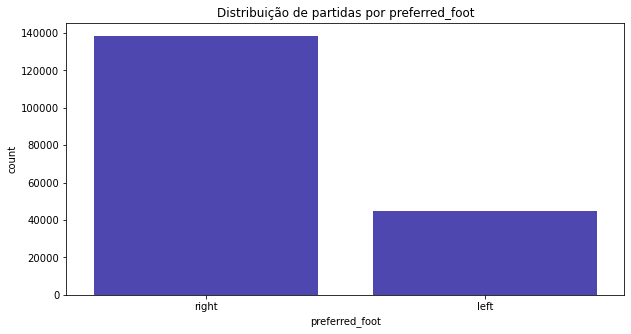

In [56]:
#avaliando distribuição de preferred_foot
plt.figure(figsize=(10,5))
sns.countplot(x=df["preferred_foot"],color='#3F35C1')
plt.title('Distribuição por preferred_foot');

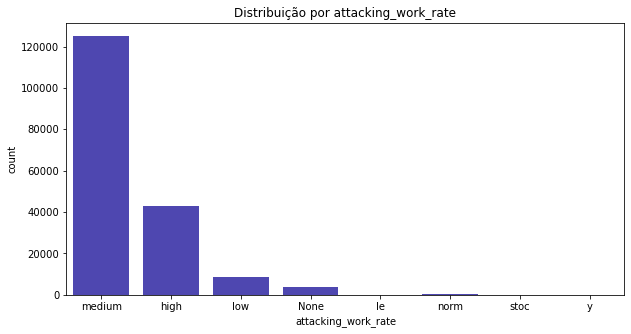

In [57]:
#avaliando distribuição de attacking_work_rate
plt.figure(figsize=(10,5))
sns.countplot(x=df["attacking_work_rate"],color='#3F35C1')
plt.title('Distribuição por attacking_work_rate');

Campo possui algums inconstências

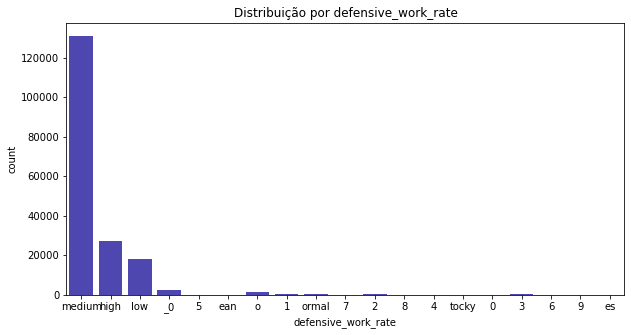

In [58]:
#avaliando distribuição de attacking_work_rate
plt.figure(figsize=(10,5))
sns.countplot(x=df["defensive_work_rate"],color='#3F35C1')
plt.title('Distribuição por defensive_work_rate');

Campo possui algums inconstências

**Inconsistências ou oportunidade de melhorias:**
- Duplicidade nos dados. **Solução proposta:** deduplicar priorizando a linha que possui informação preenchida
- Coluna right com alto volume de nulos. **Solução proposta:** remover da tabela
- Incosistências nas colunas attacking_work_rate e defensive_work_rate. **Solução proposta:** padronizar todas as incosistências deixando nulo as que não forem low, medium ou high
- Oportunidade de criar uma coluna indicando que é o status atual do jogador. **Solução proposta:** criada uma coluna booleana deixando como TRUE apenas a data mais recente para cada player_fifa_api_id

In [70]:
#criando a tabela refined_
c.execute('''
        CREATE TABLE IF NOT EXISTS refined_player_attributes_modified AS
        WITH player_attributes_modified_rn AS (
            SELECT
                player_fifa_api_id,
                attribute_id,
                date,
                overall_rating,
                potential,
                preferred_foot,
                CASE 
                    WHEN attacking_work_rate NOT IN ('low','medium','high') THEN NULL
                    ELSE attacking_work_rate END AS attacking_work_rate,
                CASE 
                    WHEN defensive_work_rate NOT IN ('low','medium','high') THEN NULL
                    ELSE defensive_work_rate END AS defensive_work_rate,
                crossing,
                finishing,
                heading_accuracy,
                short_passing,
                volleys,
                dribbling,
                curve,
                free_kick_accuracy,
                long_passing,
                ball_control,
                acceleration,
                sprint_speed,
                agility,
                reactions,
                balance,
                shot_power,
                jumping,
                stamina,
                strength,
                long_shots,
                aggression,
                interceptions,
                positioning,
                vision,
                penalties,
                marking,
                standing_tackle,
                sliding_tackle,
                gk_diving,
                gk_handling,
                gk_kicking,
                gk_positioning,
                gk_reflexes,
                ROW_NUMBER () OVER (PARTITION BY player_fifa_api_id, date ORDER BY CASE WHEN overall_rating IS NOT NULL THEN 1 ELSE 2 END) AS rn
            FROM
                player_attributes_modified
        )
        
        SELECT
            player_fifa_api_id,
            attribute_id,
            date,
            overall_rating,
            potential,
            preferred_foot,
            attacking_work_rate,
            defensive_work_rate,
            crossing,
            finishing,
            heading_accuracy,
            short_passing,
            volleys,
            dribbling,
            curve,
            free_kick_accuracy,
            long_passing,
            ball_control,
            acceleration,
            sprint_speed,
            agility,
            reactions,
            balance,
            shot_power,
            jumping,
            stamina,
            strength,
            long_shots,
            aggression,
            interceptions,
            positioning,
            vision,
            penalties,
            marking,
            standing_tackle,
            sliding_tackle,
            gk_diving,
            gk_handling,
            gk_kicking,
            gk_positioning,
            gk_reflexes,
            CASE 
                WHEN ROW_NUMBER () OVER (PARTITION BY player_fifa_api_id ORDER BY DATE(date) DESC) = 1 
                THEN TRUE ELSE FALSE END AS is_current_state
        FROM
            player_attributes_modified_rn
        WHERE
            rn = 1
''')

In [71]:
#checando os dados
c.execute('SELECT * FROM refined_player_attributes_modified').fetchone()

(2,
 64695,
 '2016-05-12 00:00:00',
 69,
 69,
 'left',
 'medium',
 'high',
 75,
 50,
 59,
 71,
 58,
 73,
 65,
 60,
 69,
 71,
 68,
 74,
 68,
 69,
 68,
 74,
 68,
 69,
 68,
 68,
 72,
 69,
 63,
 66,
 50,
 70,
 69,
 69,
 14,
 5,
 15,
 10,
 12,
 1)

In [72]:
conn.commit()

##### player

In [73]:
#olhando os dados da base
df = pd.read_sql('SELECT * FROM player',conn)
df.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


In [74]:
#checando linhas duplicadas no geral
df.duplicated().sum()

0

In [76]:
#checando linhas duplicadas pela chave
df.duplicated(subset=['player_fifa_api_id']).sum()

0

In [78]:
#checando nulos
df.isna().sum()

id                    0
player_api_id         0
player_name           0
player_fifa_api_id    0
birthday              0
height                0
weight                0
dtype: int64

In [79]:
#checando estatísticas
df.describe()

,id,player_api_id,player_fifa_api_id,height,weight
count,11060.000000,11060.000000,11060.000000,11060.000000,11060.000000
mean,5537.511392,156582.427215,165664.910488,181.867445,168.380289
std,3197.692647,160713.700624,58649.928360,6.369201,14.990217
min,1.000000,2625.000000,2.000000,157.480000,117.000000
25%,2767.750000,35555.500000,151889.500000,177.800000,159.000000
50%,5536.500000,96619.500000,184671.000000,182.880000,168.000000
75%,8306.250000,212470.500000,203883.250000,185.420000,179.000000
max,11075.000000,750584.000000,234141.000000,208.280000,243.000000


Apesar de as estatísticas estarem ok, aparentemente o campo weight está em pounds que é uma unidade de medida mais comum na Europa

<AxesSubplot:>

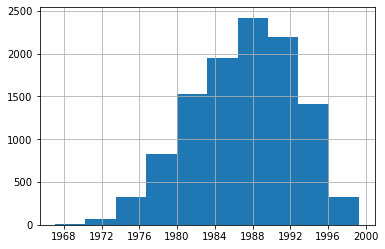

In [81]:
#Checando o campo data
pd.to_datetime(df.birthday).hist()

Considerando que temos dados desde a temporada 2008/2009, termos data de nascimento em 1968 é factível já que o jogador estaria na faixa dos 40 anos

**Inconsistências ou oportunidade de melhorias:**
- Unidade de medida não está explícita na coluna height. **Solução proposta:** Renomear a coluna explicitando
- Unidade de medida do peso está no padrão Europeu/Americano. **Solução proposta:** Converter para kg, que é a unidade com a qual nós brasileiros estamos mais habituados.

In [88]:
#criando a tabela refined_
c.execute('''
        CREATE TABLE IF NOT EXISTS refined_player AS
        SELECT
            id,
            player_api_id,
            player_name,
            player_fifa_api_id,
            birthday,
            height AS height_in_cm,
            ROUND(weight * 0.45359237,2) AS weight_in_kg
        FROM
            player
''')

In [89]:
#checando os dados
c.execute('SELECT * FROM refined_player LIMIT 5').fetchall()

[(1,
  505942,
  'Aaron Appindangoye',
  218353,
  '1992-02-29 00:00:00',
  182.88,
  84.82),
 (2, 155782, 'Aaron Cresswell', 189615, '1989-12-15 00:00:00', 170.18, 66.22),
 (3, 162549, 'Aaron Doran', 186170, '1991-05-13 00:00:00', 170.18, 73.94),
 (4, 30572, 'Aaron Galindo', 140161, '1982-05-08 00:00:00', 182.88, 89.81),
 (5, 23780, 'Aaron Hughes', 17725, '1979-11-08 00:00:00', 182.88, 69.85)]

In [90]:
#commitando criação da tabela
conn.commit()

##### team_attribuites_modified

In [91]:
#olhando os dados da base
df = pd.read_sql('SELECT * FROM team_attributes_modified',conn)
df.head()

,team_api_id,attribute_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,9930,1,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,Organised,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,9930,2,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,Organised,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,9930,3,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,Organised,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,8485,4,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,Organised,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,8485,5,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,Organised,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


In [92]:
#checando linhas duplicadas no geral
df.duplicated().sum()

0

In [94]:
#checando linhas duplicadas pela chave
df.duplicated(subset=['team_api_id','date']).sum()

3

In [98]:
#checando os duplicados
df[df.duplicated(subset=['team_api_id','date'],keep=False)].sort_values(by=['team_api_id','date']).head(10).T

,0,1458,1459,859,860
team_api_id,9930,9930,9930,9996,9996
attribute_id,1,1,2,860,861
date,2010-02-22 00:00:00,2010-02-22 00:00:00,2010-02-22 00:00:00,2015-09-10 00:00:00,2015-09-10 00:00:00
buildUpPlaySpeed,60,60,60,50,50
buildUpPlaySpeedClass,Balanced,Balanced,Balanced,Balanced,Balanced
buildUpPlayDribbling,NaN,NaN,NaN,50.0,50.0
buildUpPlayDribblingClass,Little,Little,Little,Normal,Normal
buildUpPlayPassing,50,500000,500000,50,50
buildUpPlayPassingClass,Mixed,Mixed,Mixed,Mixed,Mixed
buildUpPlayPositioningClass,Organised,Organised,Organised,Organised,Organised


1 dos times duplicado está com 2 linhas com valores exorbitantes nas colunas buildUpPlayPassing e defenceAggression. O outro time possui exatamente as mesmas informações inputadas, mudando apenas o attribute_id

In [96]:
#volume total
df.count()['team_api_id']

1460

In [95]:
#checando nulos
df.isna().sum()

team_api_id                         0
attribute_id                        0
date                                0
buildUpPlaySpeed                    0
buildUpPlaySpeedClass               0
buildUpPlayDribbling              971
buildUpPlayDribblingClass           0
buildUpPlayPassing                  0
buildUpPlayPassingClass             0
buildUpPlayPositioningClass         0
chanceCreationPassing               0
chanceCreationPassingClass          0
chanceCreationCrossing              0
chanceCreationCrossingClass         0
chanceCreationShooting              0
chanceCreationShootingClass         0
chanceCreationPositioningClass      0
defencePressure                     0
defencePressureClass                0
defenceAggression                   0
defenceAggressionClass              0
defenceTeamWidth                    0
defenceTeamWidthClass               0
defenceDefenderLineClass            0
dtype: int64

Alto volume de nulos na coluna buildUpPlayDribbling

In [99]:
#checando estatísticas
df.describe()

,team_api_id,attribute_id,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
count,1460.000000,1460.000000,1460.000000,489.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,9995.636986,728.502740,52.472603,48.607362,733.355479,52.176027,53.747260,53.970548,46.022603,124.526027,52.176027
std,13255.775250,421.605275,11.541323,9.678290,18497.696321,10.357746,11.087036,10.320556,10.221275,2033.144645,9.571840
min,1601.000000,1.000000,20.000000,24.000000,20.000000,21.000000,20.000000,22.000000,23.000000,24.000000,29.000000
25%,8459.250000,363.750000,45.000000,42.000000,40.000000,46.000000,47.000000,48.000000,39.000000,44.000000,47.000000
50%,8674.000000,728.500000,52.000000,49.000000,50.000000,52.000000,53.000000,53.000000,45.000000,48.000000,52.000000
75%,9904.000000,1093.250000,62.000000,55.000000,55.000000,59.000000,63.000000,61.000000,51.000000,55.000000,58.000000
max,274581.000000,1458.000000,80.000000,77.000000,500000.000000,80.000000,80.000000,80.000000,72.000000,55000.000000,73.000000


Apenas as duas colunas mencionadas no caso dos duplicados estão com estatísticas estranhas, sendo puxadas para cima por conta do outlier de 55000.

In [101]:
df.head().T

,0,1,2,3,4
team_api_id,9930,9930,9930,8485,8485
attribute_id,1,2,3,4,5
date,2010-02-22 00:00:00,2014-09-19 00:00:00,2015-09-10 00:00:00,2010-02-22 00:00:00,2011-02-22 00:00:00
buildUpPlaySpeed,60,52,47,70,47
buildUpPlaySpeedClass,Balanced,Balanced,Balanced,Fast,Balanced
buildUpPlayDribbling,NaN,48.0,41.0,NaN,NaN
buildUpPlayDribblingClass,Little,Normal,Normal,Little,Little
buildUpPlayPassing,50,56,54,70,52
buildUpPlayPassingClass,Mixed,Mixed,Mixed,Long,Mixed
buildUpPlayPositioningClass,Organised,Organised,Organised,Organised,Organised


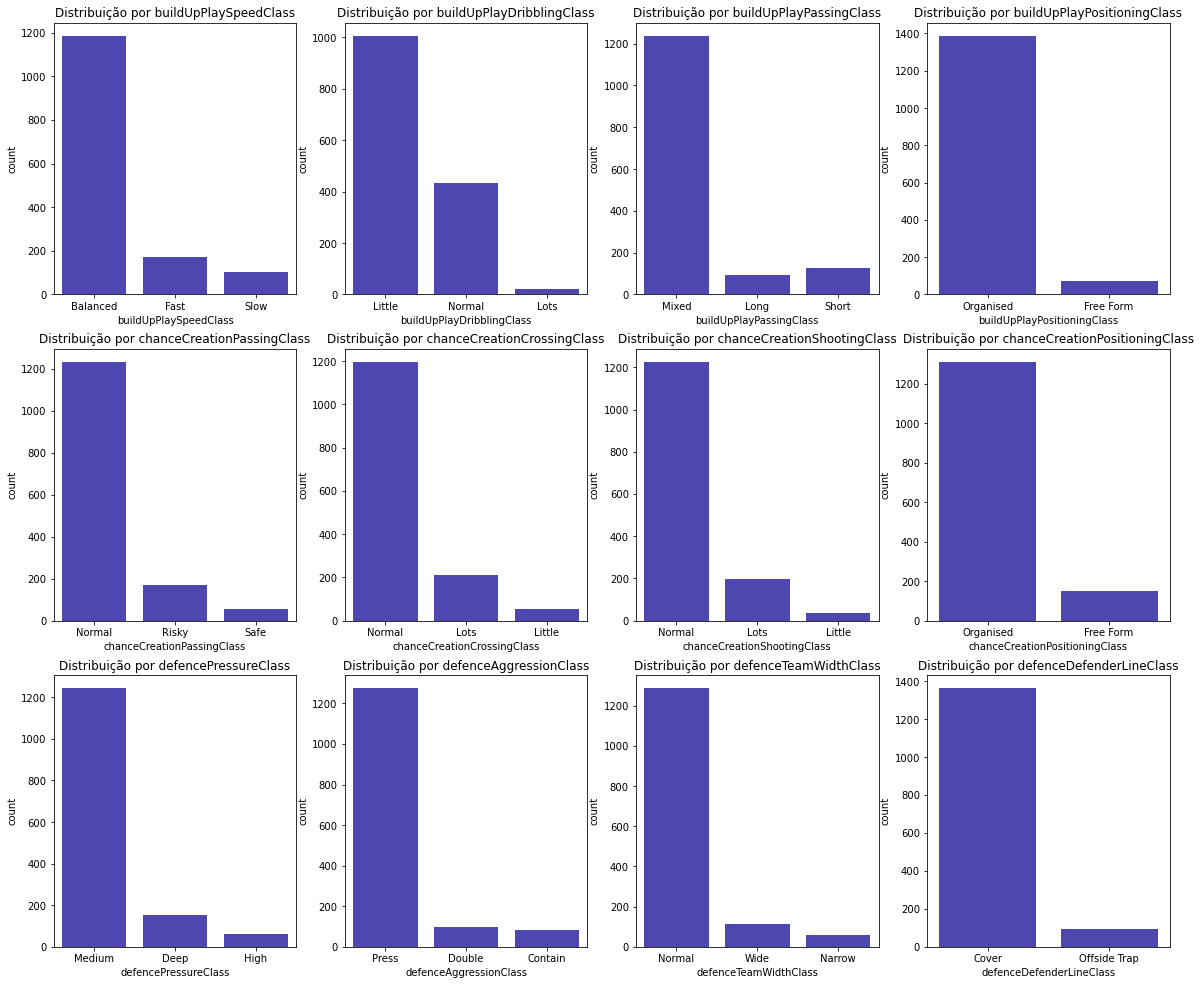

In [153]:
#avaliando distribuição das colunas categóricas
columns_list = ['buildUpPlaySpeedClass','buildUpPlayDribblingClass','buildUpPlayPassingClass','buildUpPlayPositioningClass','chanceCreationPassingClass',
                'chanceCreationCrossingClass','chanceCreationShootingClass','chanceCreationPositioningClass','defencePressureClass','defenceAggressionClass',
                'defenceTeamWidthClass','defenceDefenderLineClass']

plt.figure(figsize=(20,17))

for column in enumerate(columns_list):
    plt.subplot(3,4,column[0]+1)
    sns.countplot(x=df[column[1]],color='#3F35C1')
    plt.title('Distribuição por ' + str(column[1]))
    
plt.show()

Avaliando as variáveis categóricas parecem ok

**Inconsistências ou oportunidade de melhorias:**
- Duplicidade nos dados. **Solução proposta:** deduplicar priorizando a linha que possui o valor mais coerente nas colunas buildUpPlayPassing e defenceAggression
- Coluna buildUpPlayDribbling com alto volume de nulos. **Solução proposta:** remover da tabela
- Oportunidade de criar uma coluna indicando que é o status atual do time. **Solução proposta:** criada uma coluna booleana deixando como TRUE apenas a data mais recente para cada team_api_id

In [114]:
#criando a tabela refined_
c.execute('''
        CREATE TABLE IF NOT EXISTS refined_team_attributes_modified AS
        WITH team_attributes_modified_rn AS (
            SELECT
                team_api_id,
                attribute_id,
                date,
                buildUpPlaySpeed,
                buildUpPlaySpeedClass,
                buildUpPlayDribblingClass,
                buildUpPlayPassing,
                buildUpPlayPassingClass,
                buildUpPlayPositioningClass,
                chanceCreationPassing,
                chanceCreationPassingClass,
                chanceCreationCrossing,
                chanceCreationCrossingClass,
                chanceCreationShooting,
                chanceCreationShootingClass,
                chanceCreationPositioningClass,
                defencePressure,
                defencePressureClass,
                defenceAggression,
                defenceAggressionClass,
                defenceTeamWidth,
                defenceTeamWidthClass,
                defenceDefenderLineClass,
                ROW_NUMBER () OVER (PARTITION BY team_api_id, date ORDER BY buildUpPlayPassing, defenceAggression) AS rn
            FROM
                team_attributes_modified
        )
        
        SELECT
            team_api_id,
            attribute_id,
            date,
            buildUpPlaySpeed,
            buildUpPlaySpeedClass,
            buildUpPlayDribblingClass,
            buildUpPlayPassing,
            buildUpPlayPassingClass,
            buildUpPlayPositioningClass,
            chanceCreationPassing,
            chanceCreationPassingClass,
            chanceCreationCrossing,
            chanceCreationCrossingClass,
            chanceCreationShooting,
            chanceCreationShootingClass,
            chanceCreationPositioningClass,
            defencePressure,
            defencePressureClass,
            defenceAggression,
            defenceAggressionClass,
            defenceTeamWidth,
            defenceTeamWidthClass,
            defenceDefenderLineClass,
            CASE 
                WHEN ROW_NUMBER () OVER (PARTITION BY team_api_id ORDER BY DATE(date) DESC) = 1 
                THEN TRUE ELSE FALSE END AS is_current_state
        FROM
            team_attributes_modified_rn
        WHERE
            rn = 1
''')

In [115]:
#checando alguns dados
c.execute('SELECT * FROM refined_team_attributes_modified').fetchone()

(1601,
 1118,
 '2015-09-10 00:00:00',
 47,
 'Balanced',
 'Normal',
 38,
 'Mixed',
 'Organised',
 61,
 'Normal',
 65,
 'Normal',
 50,
 'Normal',
 'Organised',
 43,
 'Medium',
 44,
 'Press',
 49,
 'Normal',
 'Cover',
 1)

In [116]:
#commitando alteração
conn.commit()

##### team

In [5]:
#olhando os dados da base
df = pd.read_sql('SELECT * FROM team',conn)
df.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [6]:
#checando linhas duplicadas no geral
df.duplicated().sum()

0

In [7]:
#checando linhas duplicadas pela chave
df.duplicated(subset=['team_api_id']).sum()

0

In [10]:
#checando linhas duplicadas pelo nome do time
df.duplicated(subset=['team_long_name']).sum()

3

In [14]:
#avaliando os duplicados
df[df.duplicated(subset=['team_long_name'],keep=False)].sort_values(by='team_long_name')

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
182,31444,8031,111429.0,Polonia Bytom,POB
183,31445,8020,111429.0,Polonia Bytom,GOR
15,16,9996,111560.0,Royal Excel Mouscron,MOU
24,2510,274581,111560.0,Royal Excel Mouscron,MOP
189,31451,8244,301.0,Widzew Łódź,LOD
199,32409,8024,301.0,Widzew Łódź,WID


São poucos casos e que possuem team_api_id e team_short_name diferentes. Não existe insumo o suficiente para determinar se de fato é uma duplicidade ou se são homônimos

In [8]:
#checando nulos
df.isna().sum()

id                   0
team_api_id          0
team_fifa_api_id    11
team_long_name       0
team_short_name      0
dtype: int64

In [20]:
#criando a tabela refined_
c.execute('''
        CREATE TABLE IF NOT EXISTS refined_team AS
        SELECT
            id,
            team_api_id,
            team_fifa_api_id,
            team_long_name,
            team_short_name
        FROM
            team
''')

In [21]:
#checando os dados
c.execute('SELECT * FROM refined_team LIMIT 5').fetchall()

[(1, 9987, 673, 'KRC Genk', 'GEN'),
 (2, 9993, 675, 'Beerschot AC', 'BAC'),
 (3, 10000, 15005, 'SV Zulte-Waregem', 'ZUL'),
 (4, 9994, 2007, 'Sporting Lokeren', 'LOK'),
 (5, 9984, 1750, 'KSV Cercle Brugge', 'CEB')]

In [22]:
#commitando criação da tabela
conn.commit()

### Análise exploratória

A análise exploratória tem o objetivo de aprofundar nos dados coletados buscando possíveis padrões de comportamento e coletando insights que serão relavantes para o negócio.

As principais perguntas que devem ser respondidas sâo:
- Qual é o país que possui a maior média de gols por partida ?
- Qual é a liga que possui a maior média de gols por partida ?
- Quais são os principais times do mundo em cada um dos atributos disponibilizados pelo jogo FIFA ?
- Quais são os top times em estatísticas de partida ? Ex: número de gols, vitórias, derrotas, empates, etc
- Quais são os Top 3 times de cada liga por temporada ?
- Como o overall médio dos jogadores evoluiu com o tempo de acordo com o jogo FIFA ?
- Quem são os 10 melhores jogadores do mundo considerando seus atributos (dados mais recentes) de acordo com o jogo FIFA ?
- Qual é a proporção de jogadores canhotos e destros ?

#### Qual é o país que possui a maior média de gols ?

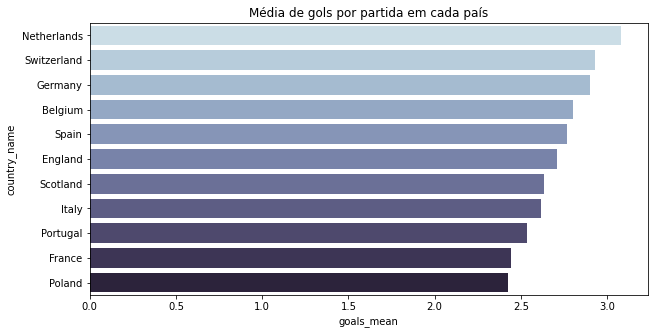

In [330]:
#recuperando dados do banco
df = pd.read_sql('''
            SELECT
                refined_country.name_en_us AS country_name,
                AVG(home_team_goal + away_team_goal) AS goals_mean
            FROM
                refined_country
            INNER JOIN
                refined_match
            ON refined_country.id = refined_match.country_id
            GROUP BY
                country_name
            ORDER BY
                goals_mean DESC
''',conn)

#plotando o resultado
plt.figure(figsize=(10,5))
sns.barplot(data=df,x='goals_mean',y='country_name', palette='ch:s=.25,rot=-.25')
plt.title('Média de gols por partida em cada país');
plt.savefig('..\\country_goals_mean.png')

Não existe uma grande diferença entre os países. A média varia entre 2.4 e 3 gols por partida, então não dá para dizer que existe um país que destoa muito dos outros.

#### Qual é a liga que possui a maior média de gols por partida ?

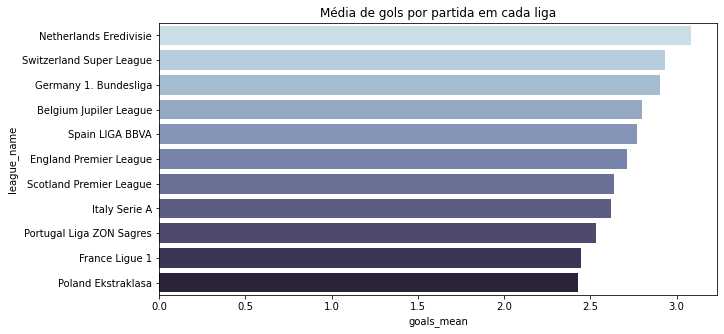

In [331]:
#recuperando dados do banco
df = pd.read_sql('''
            SELECT
                refined_league.name AS league_name,
                AVG(home_team_goal + away_team_goal) AS goals_mean
            FROM
                refined_league
            INNER JOIN
                refined_match
            ON refined_league.id = refined_match.league_id
            GROUP BY
                league_name
            ORDER BY
                goals_mean DESC
''',conn)

#plotando o resultado
plt.figure(figsize=(10,5))
sns.barplot(data=df,x='goals_mean',y='league_name', palette='ch:s=.25,rot=-.25')
plt.title('Média de gols por partida em cada liga');
plt.savefig('..\\league_goals_mean.png')

O resultado aqui reflete o gráfico anterior por país. Muito provavelmente porque cada país possui apenas uma liga nos dados fornecidos. Não temos dados de divisões inferiores, por exemplo

In [100]:
#checando a relação entre league e country
#recuperando dados do banco
df = pd.read_sql('''
            SELECT
                refined_country.name_en_us AS country_name,
                refined_league.name AS league_name
            FROM
                refined_country
            LEFT JOIN
                refined_league
            ON refined_country.id = refined_league.country_id
            
            UNION ALL
            
            SELECT
                refined_country.name_en_us AS country_name,
                refined_league.name AS league_name
            FROM
                refined_league
            LEFT JOIN
                refined_country
            ON refined_league.country_id = refined_country.id
            WHERE
                refined_country.id IS NULL
''',conn)
df.head(20)

,country_name,league_name
0,Belgium,Belgium Jupiler League
1,England,England Premier League
2,France,France Ligue 1
3,Germany,Germany 1. Bundesliga
4,Italy,Italy Serie A
5,Netherlands,Netherlands Eredivisie
6,Poland,Poland Ekstraklasa
7,Portugal,Portugal Liga ZON Sagres
8,Scotland,Scotland Premier League
9,Spain,Spain LIGA BBVA


Temos 2 ligas que não existem na tabela de country. Neste primeiro momento não irei tratar porque como não temos partidas para estas ligas não existe perda de dado na análise.

**Obs:** tive que emular um `OUTTER JOIN` pois o SQLite não possui suporte para este tipo de `JOIN`

#### Quais são os principais times do mundo em cada um dos atributos ?

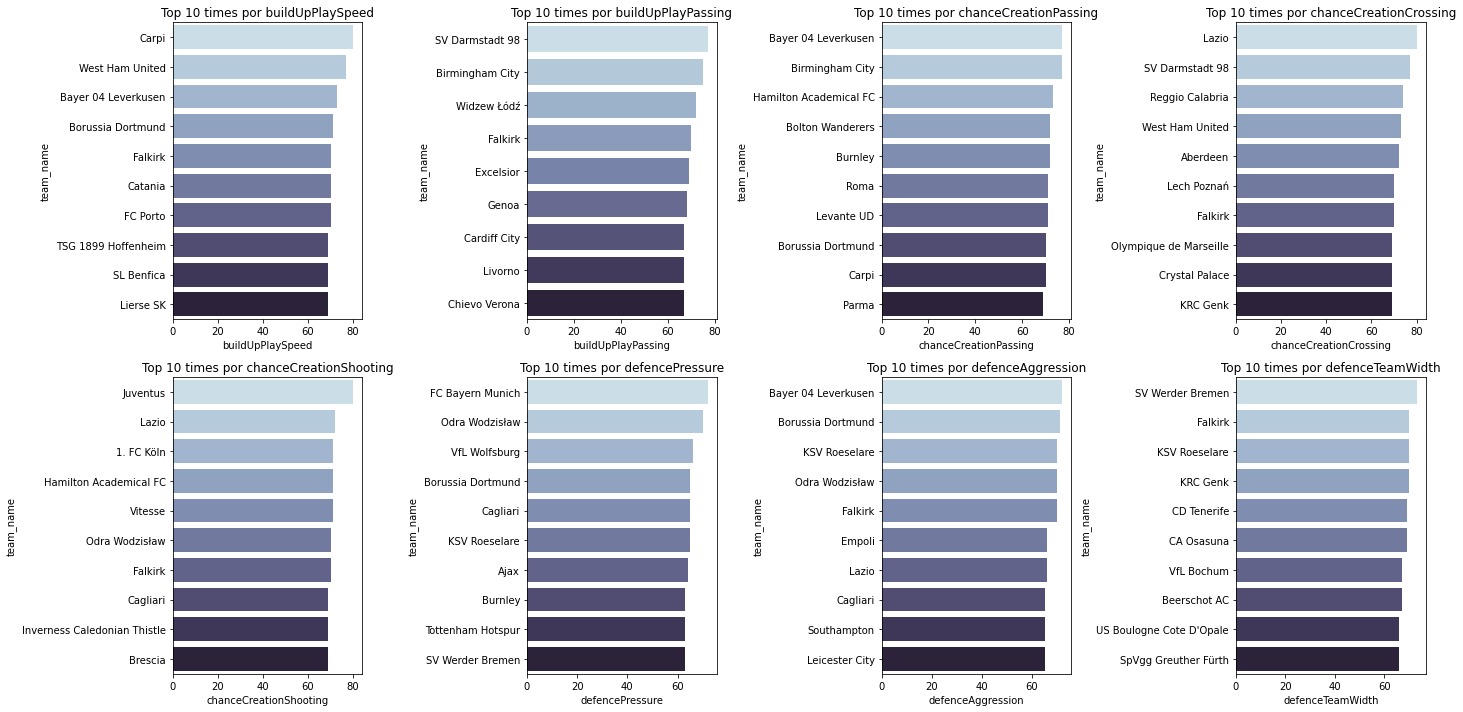

In [333]:
#recuperando dados do banco
df = pd.read_sql('''
            SELECT
                refined_team.team_long_name AS team_name,
                buildUpPlaySpeed,
                buildUpPlayPassing,
                chanceCreationPassing,
                chanceCreationCrossing,
                chanceCreationShooting,
                defencePressure,
                defenceAggression,
                defenceTeamWidth
            FROM
                refined_team_attributes_modified attributes
            INNER JOIN
                refined_team
            ON attributes.team_api_id = refined_team.team_api_id
            WHERE 
                attributes.is_current_state
''',conn)

#plotando o resultado

columns_list = ['buildUpPlaySpeed','buildUpPlayPassing','chanceCreationPassing','chanceCreationCrossing',
                'chanceCreationShooting','defencePressure','defenceAggression','defenceTeamWidth']
plt.figure(figsize=(20,10))

for column in enumerate(columns_list):
    plt.subplot(2,4,column[0]+1)
    sns.barplot(data=df.sort_values(by=column[1],ascending=False).head(10),x=column[1],y='team_name', palette='ch:s=.25,rot=-.25')
    plt.title('Top 10 times por ' + column[1])
plt.tight_layout()

Estranhamente os top 10 times em cada atributo não parecem coerente com a realidade. Existem times conhecidamente muito fortes no futebol mundial como Real Madrid, Barcelona, Manchester City e etc que pouco ou não aparecem nas listas. Talvez avaliando estatísticas da partida dê para ter uma noção maior

#### Quais são os top times em estatísticas de partida ? Ex: número de gols, vitórias, derrotas, empates, etc
Como um time pode jogar como mandante ou visitante, foi necessário aplicar uma lógica para unir os dados antes de contabilizar as estatísticas. No SQLite não identifiquei alguma função parecida com a UNPIVOT que pudesse auxiliar na remodelagem do dado.

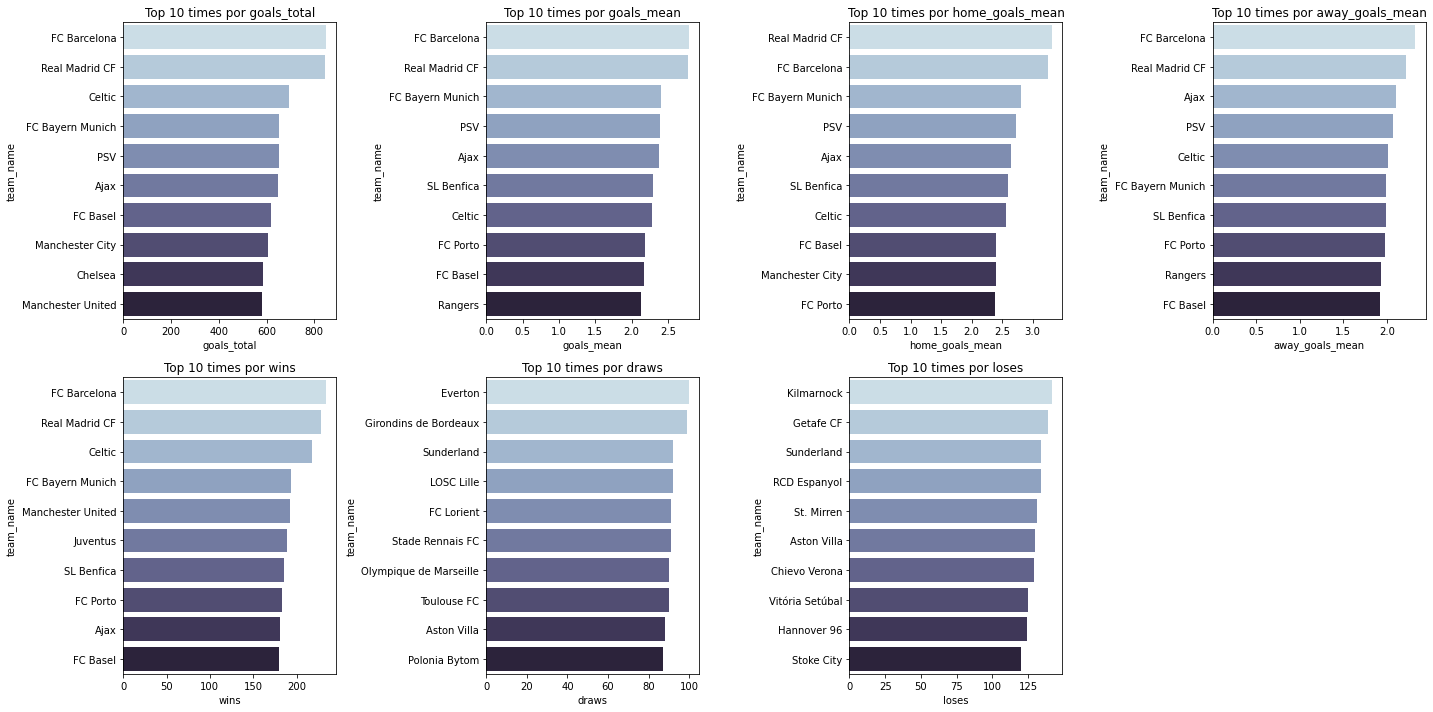

In [335]:
#recuperando dados do banco
df = pd.read_sql('''
            WITH home_team AS (
                SELECT
                    team_api_id,
                    home_team_goal AS goals,
                    home_team_wins AS win,
                    draw_match AS draw,
                    CASE WHEN away_team_wins THEN TRUE ELSE FALSE END AS lose,
                    CASE
                        WHEN home_team_wins THEN 3
                        WHEN draw_match THEN 1
                        ELSE 0 END AS points
                FROM
                    refined_match
                INNER JOIN
                    refined_team
                ON refined_team.team_api_id = refined_match.home_team_api_id
            ),
            
            away_team AS (
                SELECT
                    team_api_id,
                    away_team_goal AS goals,
                    away_team_wins AS win,
                    draw_match AS draw,
                    CASE WHEN home_team_wins THEN TRUE ELSE FALSE END AS lose,
                    CASE
                        WHEN away_team_wins THEN 3
                        WHEN draw_match THEN 1
                        ELSE 0 END AS points
                FROM
                    refined_match
                INNER JOIN
                    refined_team
                ON refined_team.team_api_id = refined_match.away_team_api_id
            ),
            
            full_matches AS (
                SELECT
                    *,
                    'home' AS source
                FROM
                    home_team
                    
                UNION ALL
                
                SELECT
                    *,
                    'away' AS source
                FROM
                    away_team
            )
            
            
            SELECT
                refined_team.team_long_name AS team_name,
                COUNT(full_matches.team_api_id) AS matches_total,
                COUNT(CASE WHEN source='home' THEN full_matches.team_api_id ELSE NULL END) AS home_matches_total,
                COUNT(CASE WHEN source='away' THEN full_matches.team_api_id ELSE NULL END) AS away_matches_total,
                SUM(full_matches.goals) AS goals_total,
                SUM(CASE WHEN source='home' THEN full_matches.goals ELSE NULL END) AS home_goals_total,
                SUM(CASE WHEN source='away' THEN full_matches.goals ELSE NULL END) AS away_goals_total,
                AVG(full_matches.goals) AS goals_mean,
                AVG(CASE WHEN source='home' THEN full_matches.goals ELSE NULL END) AS home_goals_mean,
                AVG(CASE WHEN source='away' THEN full_matches.goals ELSE NULL END) AS away_goals_mean,
                SUM(full_matches.win) AS wins,
                SUM(full_matches.draw) AS draws,
                SUM(full_matches.lose) AS loses,
                SUM(full_matches.points) AS points
            FROM
                refined_team  
            INNER JOIN
                full_matches
            ON refined_team.team_api_id = full_matches.team_api_id
            GROUP BY
                team_name
            ORDER BY
                goals_total DESC
''',conn)

#plotando o resultado

columns_list = ['goals_total','goals_mean','home_goals_mean','away_goals_mean','wins','draws','loses']
plt.figure(figsize=(20,10))

for column in enumerate(columns_list):
    plt.subplot(2,4,column[0]+1)
    sns.barplot(data=df.sort_values(by=column[1],ascending=False).head(10),x=column[1],y='team_name', palette='ch:s=.25,rot=-.25')
    plt.title('Top 10 times por ' + column[1])
plt.tight_layout()
plt.savefig('..\\top3_teams_statistics.png')

Os top 10 de cada estatísticas são bem semelhantes, exceto quando avaliamos empate e derroa (o que faz sentido). O Barcelona foi o time que mais se destacou no período, ficando atrás apenas no quesito média de gols como mandante.

O time que mais teve derrotas foi o Kilmarnock, com pouco mais de 125 derrotas.

#### Quais são os Top 3 times de cada liga por temporada ?
Como um time pode jogar como mandante ou visitante, foi necessário aplicar uma lógica para unir os dados antes de contabilizar as estatísticas. No SQLite não identifiquei alguma função parecida com a UNPIVOT que pudesse auxiliar na remodelagem do dado.

C:\Users\mayke\anaconda3\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


<Figure size 1440x1440 with 0 Axes>

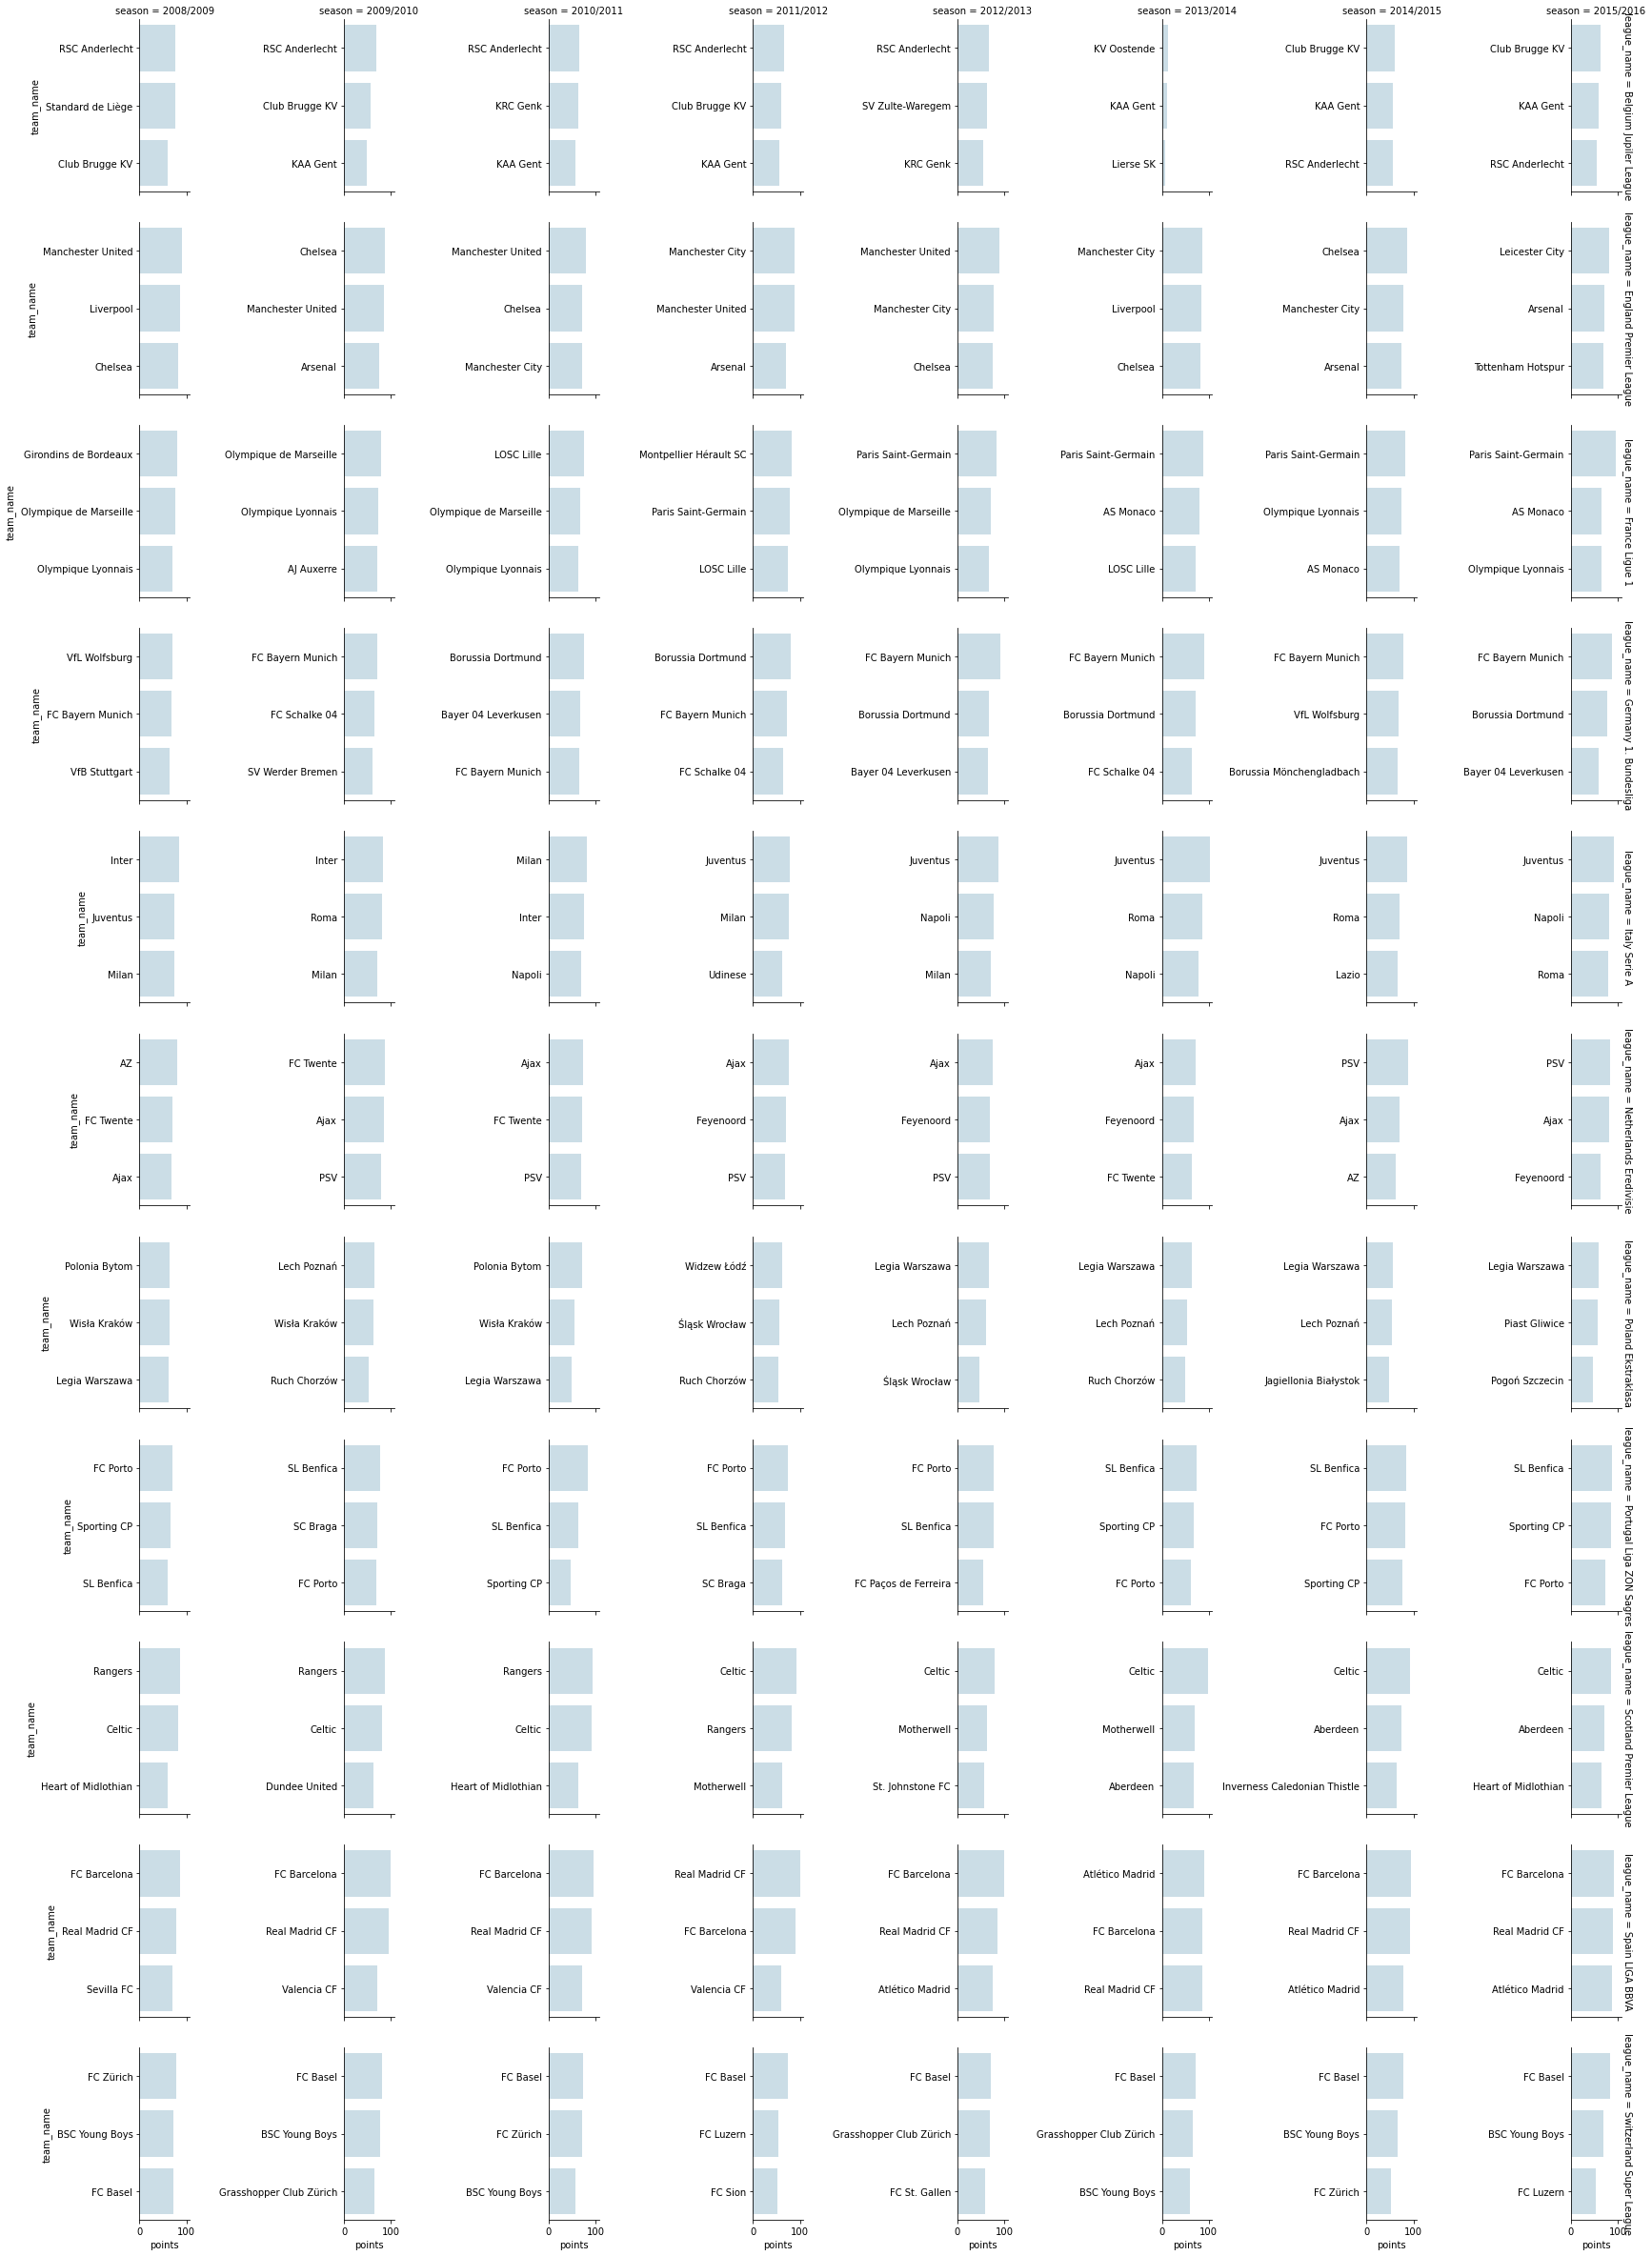

In [336]:
#recuperando dados do banco
df = pd.read_sql('''
            WITH home_team AS (
                SELECT
                    team_api_id,
                    CASE
                        WHEN home_team_wins THEN 3
                        WHEN draw_match THEN 1
                        ELSE 0 END AS points,
                    refined_league.name AS league_name,
                    refined_match.season
                FROM
                    refined_match
                INNER JOIN
                    refined_team
                ON refined_team.team_api_id = refined_match.home_team_api_id
                INNER JOIN
                    refined_league
                ON refined_match.league_id = refined_league.id
                    
            ),
            
            away_team AS (
                SELECT
                    team_api_id,
                    CASE
                        WHEN away_team_wins THEN 3
                        WHEN draw_match THEN 1
                        ELSE 0 END AS points,
                    refined_league.name AS league_name,
                    refined_match.season
                FROM
                    refined_match
                INNER JOIN
                    refined_team
                ON refined_team.team_api_id = refined_match.away_team_api_id
                INNER JOIN
                    refined_league
                ON refined_match.league_id = refined_league.id
            ),
            
            full_matches AS (
                SELECT
                    *,
                    'home' AS source
                FROM
                    home_team
                    
                UNION ALL
                
                SELECT
                    *,
                    'away' AS source
                FROM
                    away_team
            )
            
            
            SELECT
                full_matches.season,
                full_matches.league_name,
                refined_team.team_long_name AS team_name,
                SUM(full_matches.points) AS points
            FROM
                refined_team  
            INNER JOIN
                full_matches
            ON refined_team.team_api_id = full_matches.team_api_id
            GROUP BY
                full_matches.season,
                full_matches.league_name,
                refined_team.team_long_name
            ORDER BY
                points DESC
''',conn)

#selecionando top 3 times de cada temporada e liga
df_grouped = df.groupby(['season','league_name']).head(3).reset_index(drop=True).sort_values(by=['season','league_name'])

#plotando resultados
plt.figure(figsize=(20,20))
g = sns.FacetGrid(data=df_grouped,row='league_name',col='season',margin_titles=True,sharey=False)
g.map(sns.barplot,'points','team_name')
plt.tight_layout()
plt.savefig('..\\top3_teams_per_season.png')

Com uma exceção ou outra, existe uma grande regularidade nos times que mais pontuam em cada temporada por liga

#### O overall médio dos jogadores evoluiu com o tempo ?

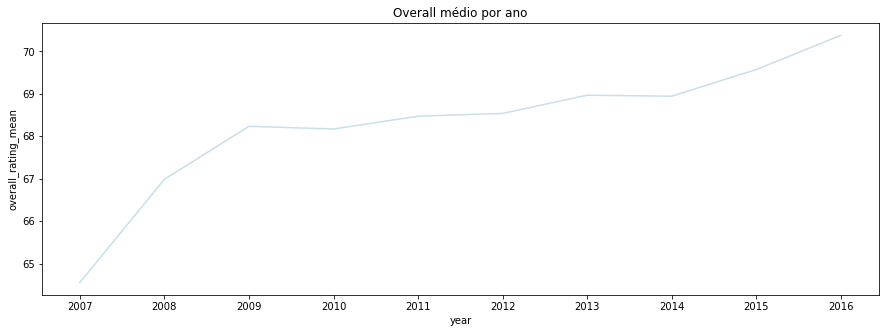

In [337]:
#recuperando dados do banco
df = pd.read_sql('''
            SELECT
                 strftime('%Y',DATE(date)) AS year,
                AVG(overall_rating) AS overall_rating_mean
            FROM
                refined_player_attributes_modified  
            GROUP BY
                year
''',conn)

#plotando resultados
plt.figure(figsize=(15,5))
sns.lineplot(data=df,x='year',y='overall_rating_mean')
plt.title('Overall médio por ano')
plt.savefig('..\\player_overall_mean.png')

O overall médio, indicador geral de performance de um jogador, está em uma tendência de evolução. A média passou de menos de 65 em 2007 para mais 70 em 2016

Text(0.5, 1.0, 'Potential médio por ano')

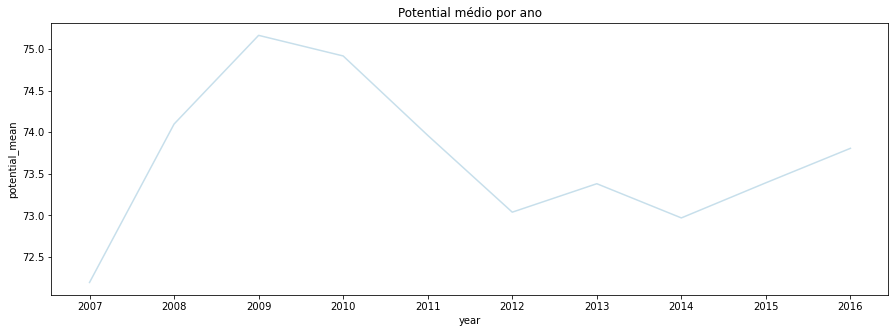

In [306]:
#recuperando dados do banco
df = pd.read_sql('''
            SELECT
                 strftime('%Y',DATE(date)) AS year,
                AVG(potential) AS potential_mean
            FROM
                refined_player_attributes_modified  
            GROUP BY
                year
''',conn)

#plotando resultados
plt.figure(figsize=(15,5))
sns.lineplot(data=df,x='year',y='potential_mean')
plt.title('Potential médio por ano')

Ao analisarmos o potencial dos jogadores podemos ver que aconteceu uma grande queda à partir de 2010 e que só parece ser retomada à partir de 2015. São poucos dados pós queda, mas a curva aparentemente aponta para uma recuperação.

#### Quem são os 10 melhores jogadores do mundo considerando seus atributos (dados mais recentes) ?

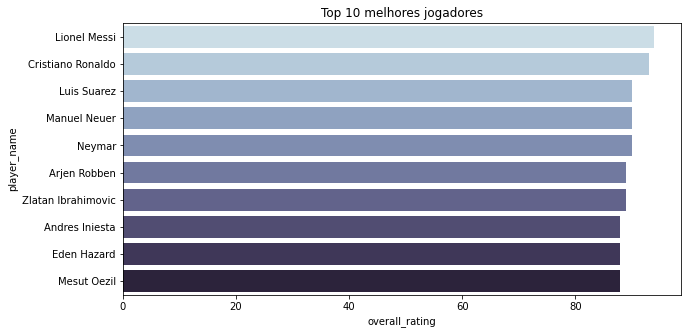

In [338]:
#recuperando dados do banco
df = pd.read_sql('''
            SELECT
                 player_name,
                 overall_rating
             FROM
                refined_player_attributes_modified attributes
            INNER JOIN
                refined_player
            ON attributes.player_fifa_api_id = refined_player.player_fifa_api_id
            WHERE
                is_current_state
            GROUP BY
                player_name,
                overall_rating
            ORDER BY 
                overall_rating DESC
            LIMIT 10
''',conn)

#plotando o resultado
plt.figure(figsize=(10,5))
sns.barplot(data=df,x='overall_rating',y='player_name', palette='ch:s=.25,rot=-.25')
plt.title('Top 10 melhores jogadores');
plt.savefig('..\\best_players.png')

#### Qual é a proporção de jogadores destros e canhotos ?

In [328]:
#recuperando dados do banco
df = pd.read_sql('''
            SELECT
                 player_name,
                 preferred_foot
             FROM
                refined_player_attributes_modified attributes
            INNER JOIN
                refined_player
            ON attributes.player_fifa_api_id = refined_player.player_fifa_api_id
            WHERE
                is_current_state
            GROUP BY
                player_name,
                preferred_foot
''',conn)

df.preferred_foot.value_counts(normalize=True)

right    0.755242
left     0.244758
Name: preferred_foot, dtype: float64

In [339]:
#fechando conexão
conn.close()